In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#light bgm model
import lightgbm as lgb
!pip install shap
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

train_df = pd.read_csv('/content/sample_data/train.csv',parse_dates=['date'])
test_df = pd.read_csv('/content/sample_data/test.csv',parse_dates=['date'])

df = pd.concat([train_df, test_df], sort=False)

print(train_df.shape, test_df.shape, df.shape, "\n")
train_df.head()

(913000, 4) (45000, 4) (958000, 5) 



,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Data Visualization

Enter store id7


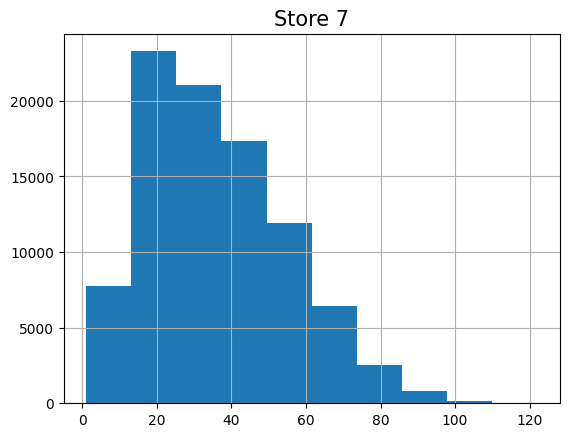

In [ ]:
#Histogram : Store sales
store= input("Enter store id")
# Filter the DataFrame for a specific store
filtered_df = train_df[train_df['store'] == int(store)]

# Create a histogram of the sales data for the store
filtered_df['sales'].hist()

# Set the title of the histogram
plt.title("Store " + str(store), fontsize=15)

plt.show()

Enter the store id :8
Enter the item number :5


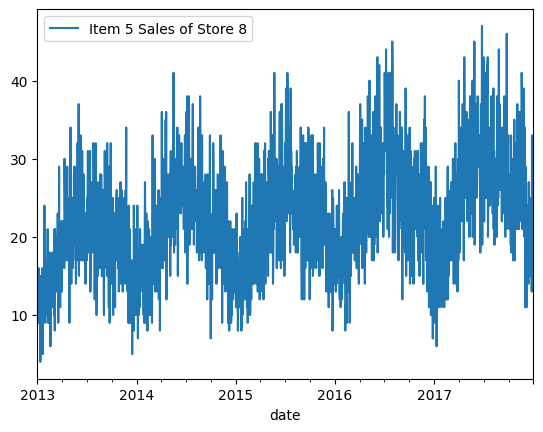

In [ ]:
#Histogram : item sales in each store

store= input("Enter the store id :")
item = input("Enter the item number :")

sub = train_df[train_df.store == int(store)].set_index("date")
sub[sub.item == int(item)].sales.plot(legend=True, label = "Item "+str(item)+" Sales"+" of Store "+str(store)) 


plt.show()

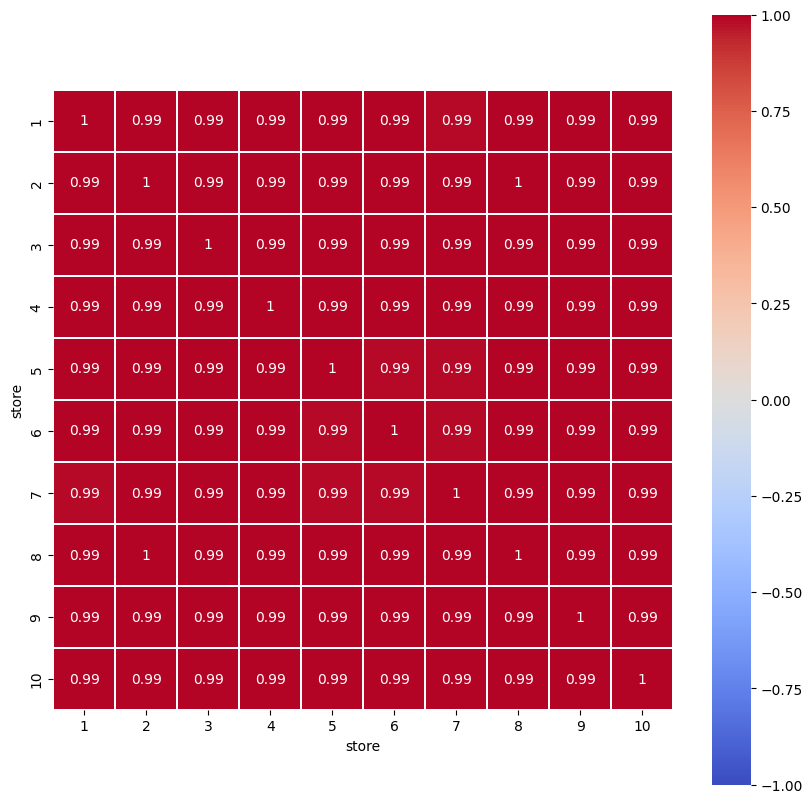

In [ ]:
##heat-map correlation

"""The correlation ranges from -1 to +1, 
where values closer to zero indicate no linear trend between the variables. 
When the correlation is close to 1, it signifies a strong positive correlation. 
This means that as one variable increases, the other variable also tends to increase, and 
the closer the correlation is to 1, the stronger this relationship becomes.."""

salestore = train_df.groupby(["date", "store"]).sales.sum().reset_index().set_index("date")
corr =  pd.pivot_table(salestore, values = "sales", columns="store", index="date").corr(method = "spearman")
plt.figure(figsize = (10,10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], 
            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True);

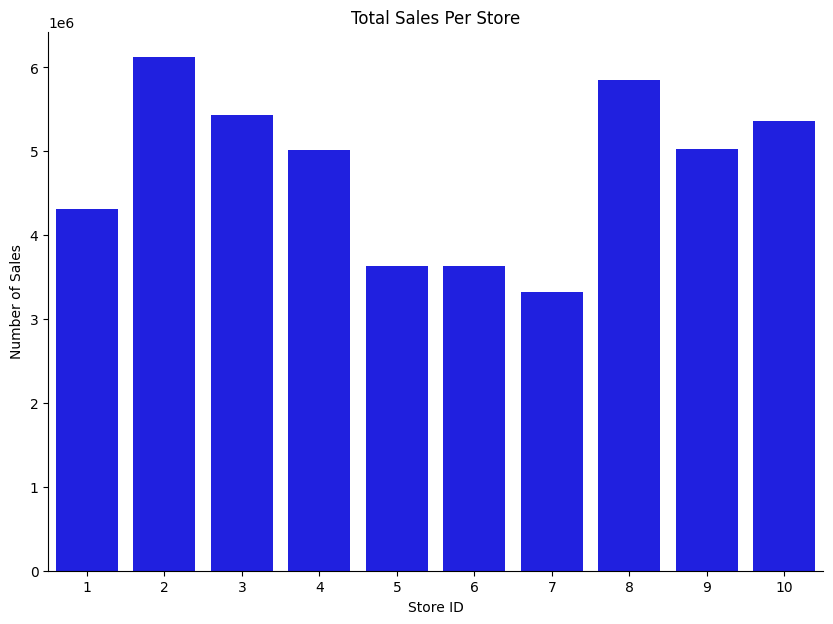

In [ ]:
#total sales per store
by_store=train_df.groupby('store')['sales'].sum().reset_index()
fig,ax=plt.subplots(figsize=(10,7))
sns.barplot(data=by_store, x="store", y="sales",color="blue")

ax.set(xlabel='Store ID',
       ylabel='Number of Sales',
       title='Total Sales Per Store')
sns.despine()

Data Cleaning:Diff transformation

In [ ]:
import datetime

In [ ]:
## checking trend / seasonality
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=x_col, y=y_col, data=data, color='blue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()  # calculate mean sales over time
    second.date = pd.to_datetime(second.date, format='%Y')

# Calculate the new x values by adding 6 months to each date
    new_x_values = second.date +datetime.timedelta(6*365/12)
# Plot the mean sales over time using lineplot
    sns.lineplot(x=new_x_values, y=y_col, data=second, ax=ax, color='red', label='Mean Sales')

    ax.set(xlabel="Date",
           ylabel="Sales",
           title=title)
    
    sns.despine()




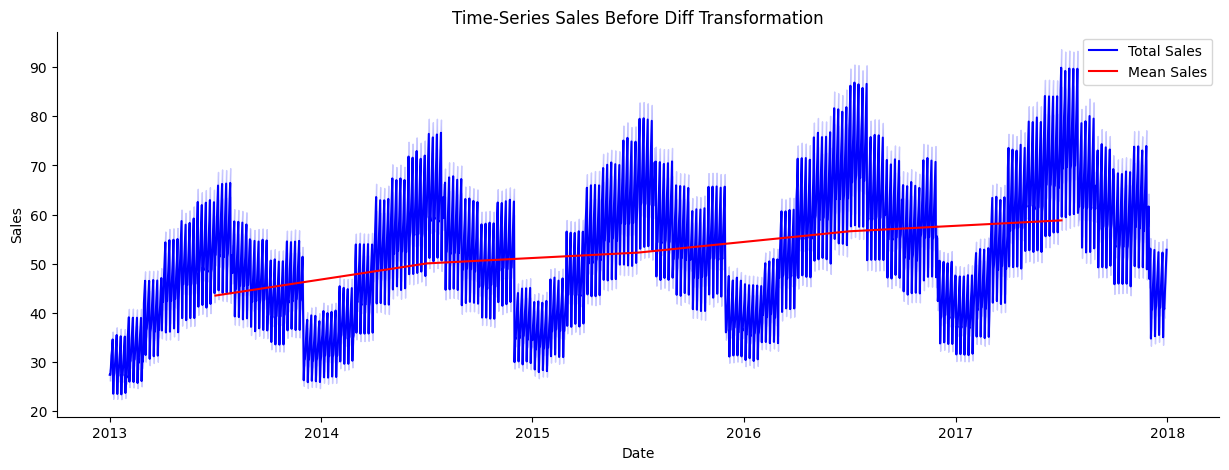

In [ ]:
# Call the function with the provided arguments
time_plot(train_df, 'date', 'sales', 'Time-Series Sales Before Diff Transformation')

In [ ]:
#data diff. --> remove trend or seasonality
"""Clearer Signal: 
Identifying and removing the seasonal component from the time series can result in a clearer relationship 
between input and output variables."""

def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('/content/sample_data/stationary_df.csv')
    return data

In [ ]:
stationary_df = get_diff(train_df)
stationary_df.tail()

,date,store,item,sales,sales_diff
912995,2017-12-27,10,50,63,22.0
912996,2017-12-28,10,50,59,-4.0
912997,2017-12-29,10,50,74,15.0
912998,2017-12-30,10,50,62,-12.0
912999,2017-12-31,10,50,82,20.0


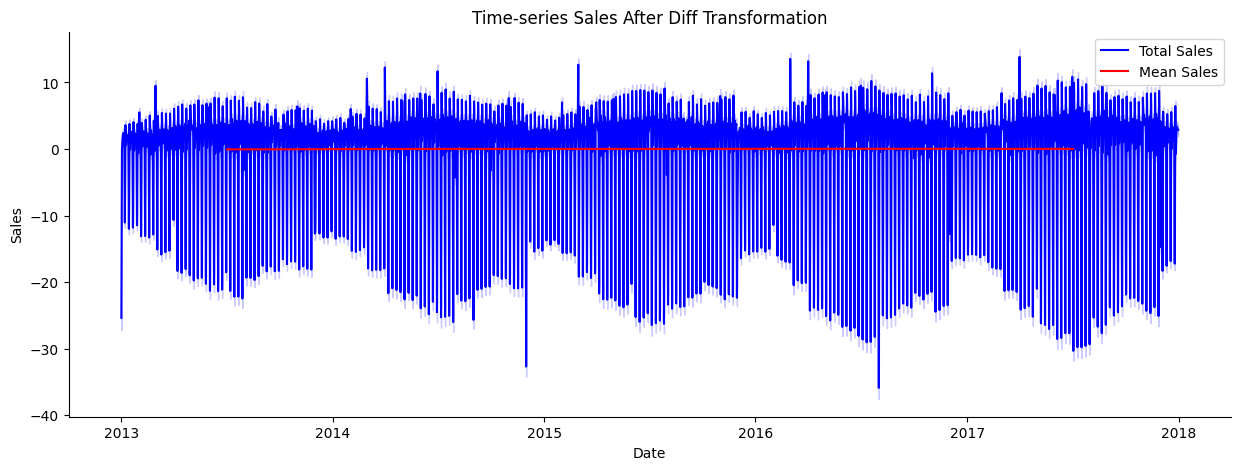

In [ ]:
time_plot(stationary_df, 'date', 'sales_diff', 'Time-series Sales After Diff Transformation')

In [ ]:
#1 Time-related feature == creating time related features

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4   ### df.date.dt.weekday => Starts from '0' means '0' = 'Monday'. 
                                               ##So, '// 4' will give '1' when day number equals
                                            ## so does for 5 and 6 gives '1' for //4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    return df
df = create_date_features(stationary_df)



In [ ]:
df.tail()

,date,store,item,sales,sales_diff,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end
912995,2017-12-27,10,50,63,22.0,12,27,361,52,3,2017,0,0,0,0,0
912996,2017-12-28,10,50,59,-4.0,12,28,362,52,4,2017,0,0,0,0,0
912997,2017-12-29,10,50,74,15.0,12,29,363,52,5,2017,1,0,0,0,0
912998,2017-12-30,10,50,62,-12.0,12,30,364,52,6,2017,1,0,0,0,0
912999,2017-12-31,10,50,82,20.0,12,31,365,52,7,2017,1,0,1,0,1


In [ ]:
#2 Lag/Shifted Features
#==> 1. every feature should be sorted 
#==> 2. generate new features for each 'item' in each 'store' according to 'date' order

#to sort 
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

#lagging ==> how many sales 1 day before in column "lag1" and so on
"""but here new features are being generated using target variable= sales 
and since target variable is being used == data leakage is possible / overfitteing of data ==> machine loses generalization ability
so adding random noise"""



#lagging 
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales_diff'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe) # Adding random noise to each value.
    return dataframe

#random noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# passing variables and creating feature
lags_list = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728] 
df = lag_features(df, lags_list) 

In [ ]:
##3 Rolling mean feature ==> takes "n" previous target variable and averages them and returns as a new value

"""For instance "roll2" takes previous 2 variable and averages it 
Again it uses target variables 
so adding noise on purpose """

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales_diff']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

roll_mean_list = [365, 546]
df = roll_mean_features(df, roll_mean_list)

In [ ]:
#4 Exponentially Weighted Mean Features ==> parameter alpha [0,1]
                                         #alpha close to 1 == more weight to close days 
    
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales_diff'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

# In here we have two combinations : alphas and lags. 
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

In [ ]:
df.tail(100)

,date,store,item,sales,sales_diff,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
912900,2017-09-23,10,50,97,0.0,9,23,266,38,6,2017,1,0,0,0,0,31.770316,-1.966405,18.833106,3.651550,2.434887,34.565382,4.915940,14.155210,6.074697,6.895566,-1.484388,2.504012,30.656752,0.809984,14.915818,5.642050,-14.139979,-1.094711,-6.163118,4.839912,5.429353,29.323700,1.621415,14.765916,4.466520,-13.259737,-1.177446,-5.355784,4.749421,5.004506,26.659061,3.150058,14.274492,2.648590,-11.438222,-1.297001,-3.857150,4.714449,4.508623,23.915709,4.407185,13.507819,1.493562,-9.544170,-1.338133,-2.567879,4.761165,4.326373,17.676143,5.546247,10.919621,0.711434,-5.734958,-1.127792,-0.824200,4.528712,4.075912
912901,2017-09-24,10,50,99,2.0,9,24,267,38,7,2017,1,0,0,0,0,-21.652947,29.029782,20.029328,23.554509,9.074244,-33.017601,2.372186,14.305804,2.029877,-0.772441,-3.043591,-1.480388,-19.367162,27.590499,20.695791,22.132102,-6.406999,-16.204736,13.941844,4.041996,-0.678532,-16.867630,26.262142,20.376592,21.146652,-6.725974,-15.417745,12.964422,4.074942,-0.399549,-12.268188,23.830012,19.654898,18.929718,-7.087644,-13.859400,11.228570,4.142890,0.101725,-8.225287,21.622156,18.752346,16.548069,-7.063251,-12.301440,9.729636,4.228350,0.597912,-2.161929,17.273124,15.959810,11.855717,-5.867479,-9.063896,7.087900,4.264356,1.537956
912902,2017-09-25,10,50,63,-36.0,9,25,268,39,1,2017,0,0,0,0,0,-23.334155,-75.409581,-54.888312,-43.948945,-44.098043,-26.497813,-13.585871,-69.219309,-31.360891,-20.688132,0.815626,-0.084763,-24.718358,-68.920475,-51.215210,-41.643395,12.029650,22.939763,16.847092,-30.197900,-19.983927,-24.186763,-63.973786,-47.462341,-38.385335,11.027403,20.958226,16.596442,-28.392506,-18.939955,-22.453638,-54.433998,-40.069020,-32.214056,8.982471,17.228120,15.845714,-24.771422,-16.779655,-19.967586,-45.313353,-32.874296,-26.535579,6.981025,13.809568,14.818891,-21.131495,-14.520626,-13.580964,-28.363438,-19.520095,-16.572141,3.566260,7.968052,12.043950,-13.867822,-9.731022
912903,2017-09-26,10,50,79,16.0,9,26,269,39,2,2017,0,0,0,0,0,2.131247,6.886709,20.541734,-1.475977,20.136197,4.936101,-7.139511,48.132893,22.764660,-4.018885,-0.540883,-2.308369,-0.285918,2.253976,17.389239,-2.082170,-4.148517,-3.603012,-63.757645,19.390105,-4.799196,-1.518676,-0.997379,14.153766,-3.838533,-3.397260,-2.404177,-59.540356,16.960749,-5.493995,-3.690728,-6.086800,8.786196,-6.442811,-2.203506,-0.554376,-51.230857,12.645716,-6.555931,-5.290276,-9.394006,4.837711,-7.960674,-1.405693,0.642870,-43.154333,9.060551,-7.156188,-6.290482,-11.1

In [ ]:
##Done few feature engineering now shape of data:
df.shape

(912999, 73)

In [ ]:
#5 one-hot encoding ==> ensures that machine learning does not assume that higher numbers are more important
#normalization

df = pd.get_dummies(df, columns=['store', 'item'])
df.head()

,date,sales,sales_diff,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
1,2013-01-02,11,-2.0,1,2,2,1,3,2013,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14,3.0,1,3,3,1,4,2013,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13,-1.0,1,4,4,1,5,2013,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10,-3.0,1,5,5,1,6,2013,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2013-01-06,12,2.0,1,6,6,1,7,2013,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#fill NAN values with mean
df['sales_lag_91'].fillna(int(df['sales_lag_91'].mean()), inplace=True)
df['sales_lag_98'].fillna(int(df['sales_lag_98'].mean()), inplace=True)
df['sales_lag_105'].fillna(int(df['sales_lag_105'].mean()), inplace=True)
df['sales_lag_112'].fillna(int(df['sales_lag_112'].mean()), inplace=True)
df['sales_lag_119'].fillna(int(df['sales_lag_119'].mean()), inplace=True)
df['sales_lag_126'].fillna(int(df['sales_lag_126'].mean()), inplace=True)
df['sales_lag_182'].fillna(int(df['sales_lag_182'].mean()), inplace=True)
df['sales_lag_364'].fillna(int(df['sales_lag_364'].mean()), inplace=True)
df['sales_lag_546'].fillna(int(df['sales_lag_546'].mean()), inplace=True)
df['sales_lag_728'].fillna(int(df['sales_lag_728'].mean()), inplace=True)

In [ ]:
df['sales_roll_mean_365'].fillna(int(df['sales_roll_mean_365'].mean()),inplace=True)
df['sales_roll_mean_546'].fillna(int(df['sales_roll_mean_546'].mean()),inplace=True)


In [ ]:
df['sales_ewm_alpha_095_lag_91'].fillna(int(df['sales_ewm_alpha_095_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_98'].fillna(int(df['sales_ewm_alpha_095_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_105'].fillna(int(df['sales_ewm_alpha_095_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_112'].fillna(int(df['sales_ewm_alpha_095_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_180'].fillna(int(df['sales_ewm_alpha_095_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_270'].fillna(int(df['sales_ewm_alpha_095_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_365'].fillna(int(df['sales_ewm_alpha_095_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_546'].fillna(int(df['sales_ewm_alpha_095_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_728'].fillna(int(df['sales_ewm_alpha_095_lag_728'].mean()),inplace=True)


In [ ]:
df['sales_ewm_alpha_09_lag_91'].fillna(int(df['sales_ewm_alpha_09_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_98'].fillna(int(df['sales_ewm_alpha_09_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_105'].fillna(int(df['sales_ewm_alpha_09_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_112'].fillna(int(df['sales_ewm_alpha_09_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_180'].fillna(int(df['sales_ewm_alpha_09_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_270'].fillna(int(df['sales_ewm_alpha_09_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_365'].fillna(int(df['sales_ewm_alpha_09_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_546'].fillna(int(df['sales_ewm_alpha_09_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_728'].fillna(int(df['sales_ewm_alpha_09_lag_728'].mean()),inplace=True)

In [ ]:
df['sales_ewm_alpha_08_lag_91'].fillna(int(df['sales_ewm_alpha_08_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_98'].fillna(int(df['sales_ewm_alpha_08_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_105'].fillna(int(df['sales_ewm_alpha_08_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_112'].fillna(int(df['sales_ewm_alpha_08_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_180'].fillna(int(df['sales_ewm_alpha_08_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_270'].fillna(int(df['sales_ewm_alpha_08_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_365'].fillna(int(df['sales_ewm_alpha_08_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_546'].fillna(int(df['sales_ewm_alpha_08_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_728'].fillna(int(df['sales_ewm_alpha_08_lag_728'].mean()),inplace=True)


In [ ]:
df['sales_ewm_alpha_07_lag_91'].fillna(int(df['sales_ewm_alpha_07_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_98'].fillna(int(df['sales_ewm_alpha_07_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_105'].fillna(int(df['sales_ewm_alpha_07_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_112'].fillna(int(df['sales_ewm_alpha_07_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_180'].fillna(int(df['sales_ewm_alpha_07_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_270'].fillna(int(df['sales_ewm_alpha_07_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_365'].fillna(int(df['sales_ewm_alpha_07_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_546'].fillna(int(df['sales_ewm_alpha_07_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_728'].fillna(int(df['sales_ewm_alpha_07_lag_728'].mean()),inplace=True)


In [ ]:
df['sales_ewm_alpha_05_lag_91'].fillna(int(df['sales_ewm_alpha_05_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_98'].fillna(int(df['sales_ewm_alpha_05_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_105'].fillna(int(df['sales_ewm_alpha_05_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_112'].fillna(int(df['sales_ewm_alpha_05_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_180'].fillna(int(df['sales_ewm_alpha_05_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_270'].fillna(int(df['sales_ewm_alpha_05_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_365'].fillna(int(df['sales_ewm_alpha_05_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_546'].fillna(int(df['sales_ewm_alpha_05_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_728'].fillna(int(df['sales_ewm_alpha_05_lag_728'].mean()),inplace=True)

In [ ]:
df.head(100)

,date,sales,sales_diff,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
1,2013-01-02,11,-2.0,1,2,2,1,3,2013,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14,3.0,1,3,3,1,4,2013,0,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13,-1.0,1,4,4,1,5,2013,1,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10,-3.0,1,5,5,1,6,2013,1,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2013-01-06,12,2.0,1,6,6,1,7,2013,1,0,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,

Split Dataset

In [ ]:
#  split into train and validation set.
#train.csv is further divided into train and validation set

train = df.loc[(df["date"] < "2017-01-01"), :] # Until beginning of 2017
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :] # First 3 months of 2017

#dropping useless column
cols = [col for col in train.columns if col not in ['date', 'id', "sales","sales_diff" "year"]]

Y_train = train['sales_diff']
X_train = train[cols]

Y_val = val['sales_diff']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730499,), (730499, 129), (45000,), (45000, 129))

Result Evaluation

In [ ]:
# #Smape score
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

# Calculating SMAPE for LightGBM output:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False 


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score ,mean_absolute_percentage_error

In [ ]:
#lgbm in without any parameters 
first_model = lgb.LGBMRegressor().fit(X_train, Y_train)

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))
print("MAPE:",mean_absolute_percentage_error(Y_train, pred))

TRAIN SMAPE: 7.525395350367996
VALID SMAPE: 7.536043367368776
MAE: 0.0006633599832766945
RMSE: 0.0011812915548323432
R2 Score: 0.9999938758752789
MAPE: 1607953149.8395905


CatBoost Regressor

In [ ]:

!pip install catboost
from catboost import CatBoostRegressor
first_model = CatBoostRegressor()
first_model.fit(X_train, Y_train)
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))
print("MAPE:",mean_absolute_percentage_error(Y_train, pred))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Learning rate set to 0.116046
0:	learn: 12.3902167	total: 318ms	remaining: 5m 17s
1:	learn: 11.0571811	total: 586ms	remaining: 4m 52s
2:	learn: 9.8781444	total: 812ms	remaining: 4m 29s
3:	learn: 8.8154184	total: 1.07s	remaining: 4m 25s
4:	learn: 7.8787813	total: 1.31s	remaining: 4m 21s
5:	learn: 7.0476221	total: 1.56s	remaining: 4m 19s
6:	learn: 6.2971506	total: 1.8s	remaining: 4m 15s
7:	learn: 5.6329425	total: 2.04s	remaining: 4m 13s
8:	learn: 5.0382493	total: 2.29s	remaining: 4m 12s
9:	learn: 4.5076309	total: 2.53s	remaining: 4m 10s
10:	learn: 4.0395120	total: 2.79s	remaining: 4m 10s
11:	learn: 3.6201104	total: 3.02s	remaining: 4m 8s
12:	learn: 3.2451889	total: 3.25s	remaining: 4m 6s
13:	learn: 2.9062985	total: 3.49s	remaining: 4m 5s
14:	learn: 2.6053370	total: 3.71s	remaining: 4m 3s
15:	learn: 2.3358228	total: 3.95s	remaining: 4m 3s
16:	learn: 2.0995118	total: 4.21s	remaining: 4m 3s
17

Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
first_model = LinearRegression()
first_model.fit(X_train, Y_train)
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))
print("MAPE:",mean_absolute_percentage_error(Y_train, pred))

TRAIN SMAPE: 7.522255335052079
VALID SMAPE: 7.533333333333682
MAE: 2.2997462850539253e-14
RMSE: 9.619546781399901e-28
R2 Score: 1.0
MAPE: 1.58358553787259


Conclusion

In [ ]:
"""After removing the trend or seasonality using differentiation transformation, MAE & RMSE for all the models were 
very close to zero and R2 score very close to 1. Hence, to conclude the data was overfit after
differentiation transformation and would not give the desired output.""" 

'After removing the trend or seasonality using differentiation transformation, MAE & RMSE for all the models were \nvery close to zero and R2 score very close to 1. Hence, to conclude the data was overfit after\ndifferentiation transformation and would not give the desired output.'